## COMP30027 Machine Learning Assignment 2 Coding Part

In [1]:
import numpy as np
import pandas as pd
import pickle
import csv
import re
import nltk
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

## Read in Datasets

In [2]:
# read text from training and test set
# for DEMONSTRATION PURPOSES, the entire training set will be used to train the models and also as a test set
train_original = pd.read_csv(r"recipe_train.csv", index_col = False, delimiter = ',', header=0)
test_original = pd.read_csv(r"recipe_test.csv", index_col = False, delimiter = ',', header = 0)

## Explore Data Analysis

In [3]:
# EDA part
# explore the data structure data type 
print(train_original.info())
# there is no missing value in train and test data set
print(train_original.isnull().sum())
print(test_original.isnull().sum())
# for n_steps, the 75% is 12 steps while the maximum is 82 steps
# for n_ingredients, the 75% is 11 while the maximum is 40
print(train_original.describe())
trainset_ingr = train_original['ingredients']
trainset_step = train_original['steps']
train_y = train_original['duration_label']
test_ingr = test_original['ingredients']
test_step = test_original['steps']
# 3 distinct label (type float64), 1.0: 17705, 2.0: 20246, 3.0: 2049
# label for train set is imbalanced
print(train_y.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            40000 non-null  object 
 1   n_steps         40000 non-null  int64  
 2   n_ingredients   40000 non-null  int64  
 3   steps           40000 non-null  object 
 4   ingredients     40000 non-null  object 
 5   duration_label  40000 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ MB
None
name              0
n_steps           0
n_ingredients     0
steps             0
ingredients       0
duration_label    0
dtype: int64
name             0
n_steps          0
n_ingredients    0
steps            0
ingredients      0
dtype: int64
            n_steps  n_ingredients  duration_label
count  40000.000000    40000.00000    40000.000000
mean       9.705025        9.09970        1.608600
std        5.748442        3.66157        0.583665
min        1.000000 

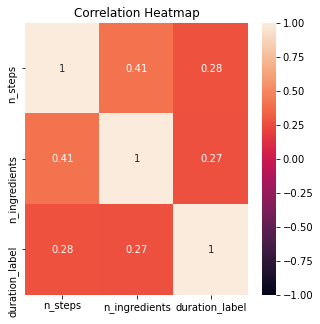

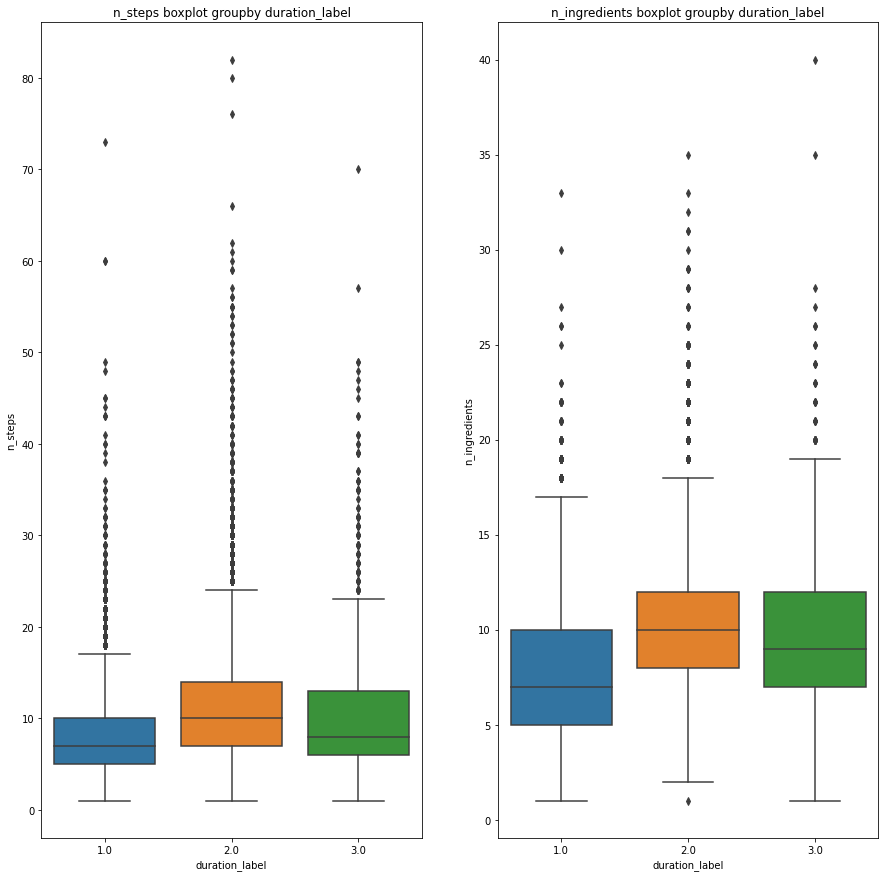

In [4]:
# explore relation between numeric columns
# correlation plot
# the correlation between n_steps and n_ingrediant is larger than the correlation between n_steps(n_ingredient) vs duration label
# reference source: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
plt.figure(figsize=(5, 5))
corr = sns.heatmap(train_original.corr(), vmin=-1, vmax=1, annot=True)
corr.set_title('Correlation Heatmap')
plt.savefig("correlation heatmap.png")

# boxplot
fig = plt.figure(figsize = [15,15])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.title.set_text('n_steps boxplot groupby duration_label')
ax2.title.set_text('n_ingredients boxplot groupby duration_label')
sns.boxplot(x = train_original['duration_label'], y = train_original["n_steps"], ax = ax1)
sns.boxplot(x = train_original['duration_label'], y = train_original["n_ingredients"], ax = ax2)
plt.show()
fig.savefig("data boxplot.png")

In [5]:
# explore non-numeric columns
trainset_ingr = train_original['ingredients']
trainset_step = train_original['steps']
trainset_name = train_original["name"]
y_train = train_original['duration_label']
testset_ingr = test_original['ingredients']
testset_step = test_original['steps']

# modify the display max column width
pd.set_option("display.max_colwidth",1000)
train_original[['steps', 'duration_label']].head(20)
# in steps, there are some simple and quick steps like "mix ingredient in a bowl", "remove from heat"
# and also steps required long time like "refrigerate overnight or 4 hours minimum covered in foil"
# so this also proves that n_steps has little correlation with duration_label, since the weight for each step is different

# Moreover, we noticed that few steps contain the approximate time, for instance "cover and simmer about 40 minutes until tender" and "refrigerate overnight or 4 hours minimum covered in foil"
# which can be extract in later steps as a new feature

,steps,duration_label
0,"['in saucepan , melt margarine and combine with olive oil', 'add celery & onion and saute until tender', 'add garlic for the last minute', 'add carrots , broth , rice and pepper and bring to a boil', 'reduce heat , cover , and simmer for 35 minutes , or until rice is tender', 'stir in chicken and parsley , cover , and simmer for 5 minutes longer or until heated through']",2.0
1,"['melt 1 tbs butter in a small saucepan over med high heat', 'when the butter stops foaming , add the oats and stir well for 1 minute', 'reduce heat to low , and let the oats cook for 1 more minute', 'add the water , stir and place the lid on tightly', 'allow to simmer for 20 minutes , or until the majority of the water is absorbed', 'add the half and half and turn off the heat', 'replace the lid and allow to sit for 5 minutes', 'add the remaining 2 tbs butter and salt to taste', 'brown sugar and cinnamon may be added if you prefer sweet oats']",2.0
2,"['brown ground beef , onion and green pepper', 'drain', 'stir tomato sauce , chili powder and garlic salt', 'simmer while preparing dough', 'separate biscuit dough into 10 biscuits', 'pull each apart into 2 layers', 'press 10 biscuit layers over bottom of ungreased 9 inch baking pan', 'combine 1 / 2 cup cheese , sour cream and egg', 'mix well', 'remove meat mixture from heat', 'stir in sour cream mixture', 'spoon over biscuits', 'arrange remaining biscuit layers on top', 'sprinkle with remaining cheese', 'bake at 375 degrees for 30 to 35 minutes or until biscuits are a deep golden brown']",2.0
3,"['brown chicken in oil', 'combine all ingredients except cornstarch and bring to a boil', 'reduce heat', 'cover and simmer about 40 minutes until tender', 'combine cornstarch with 1 / 2 cup cold water and mix until blended', 'stir mixture into chicken mixture until thick and bubbly', 'allow to cool if you want to freeze it', 'if frozen , may need a little extra water when reheating', 'serve over rice or noodles', 'great with frozen green beans mixed in !']",2.0
4,"['set almond bark aside', 'mix remaining ingredients together in a bowl', 'refrigerate for 1 hour', 'melt almond bark', 'form crumb mixture into balls and dip in melted almond bark , place on waxed paper', 'allow the almond bark to cool and set up']",2.0
5,"['butter a large deep casserole dish', 'cube or shred by hand a loaf of sour dough bread', 'fry sausage until cooked crumbled into chunks drain and cool', 'wisk eggs , spice , milk , salt , pepper together', 'place a single layer of bread cubes in pan bottom', 'sprinkle 1 / 2 of each cheese on top of bread', 'sprinkle 1 / 2 of sausage on top of cheese and bread', 'layer rest of bread and cheese and sausage as before', 'pour egg mixture over bread layers', 'dot top of casserole with butter cubes', 'refrigerate overnight or 4 hours minimum covered in foil', 'preheat oven 350 degrees and bake uncovered 35-45 minutes', 'allow to rest 5 minutes before serving']",2.0
6,"['combine curry powder with 1 / 2 tsp', 'of salt and pepper', 'sprinkle / rub this mixture onto chicken', 'in skillet , combine juice , rice , water , sugar , mustard and rest of salt', 'arrange chicken over this mixture', 'bring to a boil', 'cover and simmer for 20-30 minutes', 'remove from heat and let stand 5 minutes', 'adjust seasonings', 'you may add more curry for desired spice']",2.0
7,"['line bottom and sides of a 9x5 loaf pan with plastic wrap', 'spread out 1 cup raspberries on bottom of pan and put in freezer', 'place yolks in top of a double boiler', 'whisk in grand marnier , milk and 2 tsp vanilla until combined', 'slowly whisk in sugar', 'place over a saucepan of simmering water', 'continuously whisk yolk mixture until pale yellow in colour , 4 to 5 minutes', 'remove from heat', 'refrigerate uncovered , until cold', 'in a large mixing bowl whip 2 cups of cream until soft peaks form', 'stir a third of cream into cold egg mixture', 'fold in remaining cream until no yellow streaks remain', 'fold in 3 ounc

In [6]:
train_original[['ingredients', 'duration_label']].head(50)
# there are some ingredients like "beef", "chicken breasts" which take time to cook
# there are also some ingredients like "water", "sea salt" which do not require any time to process
# since the weight of ingredients are also different, so we cannot just use n_steps and n_ingredients to predict duration_label

,ingredients,duration_label
0,"['margarine', 'olive oil', 'celery', 'onion', 'garlic clove', 'carrots', 'low sodium chicken broth', 'brown rice', 'pepper', 'salt substitute', 'boneless skinless chicken breasts', 'fresh parsley']",2.0
1,"['butter', 'pinhead oats', 'water', 'half-and-half', 'salt']",2.0
2,"['ground beef', 'onion', 'green pepper', 'tomato sauce', 'chili powder', 'garlic salt', 'refrigerated biscuits', 'cheddar cheese', 'sour cream', 'egg']",2.0
3,"['boneless skinless chicken', 'frozen lemonade', 'oil', 'catsup', 'vinegar', 'water', 'brown sugar', 'cornstarch']",2.0
4,"['graham cracker crumbs', 'crunchy peanut butter', 'powdered sugar', 'crisp rice cereal', 'almond bark']",2.0
5,"['sourdough bread', 'eggs', 'dried thyme', 'breakfast sausage', 'sharp cheddar cheese', 'monterey jack cheese', 'milk', 'butter', 'salt', 'pepper']",2.0
6,"['curry powder', 'salt', 'black pepper', 'skinless chicken breasts', 'orange juice', 'rice', 'water', 'brown sugar', 'mustard powder']",2.0
7,"['frozen unsweetened raspberries', 'egg yolks', 'grand marnier', 'milk', 'vanilla', 'white sugar', 'semisweet chocolate', 'whipping cream', 'seedless raspberry jam']",3.0
8,"['dried onion', 'black pepper', ""campbell's healthy request cream of broccoli soup"", 'nonfat sour cream', 'low-fat sharp cheddar cheese', 'kraft healthy favorites fat free cheddar', 'potatoes', 'corn flakes']",2.0
9,"['garlic', 'dijon mustard', 'fresh lime juice', 'skirt steaks']",2.0


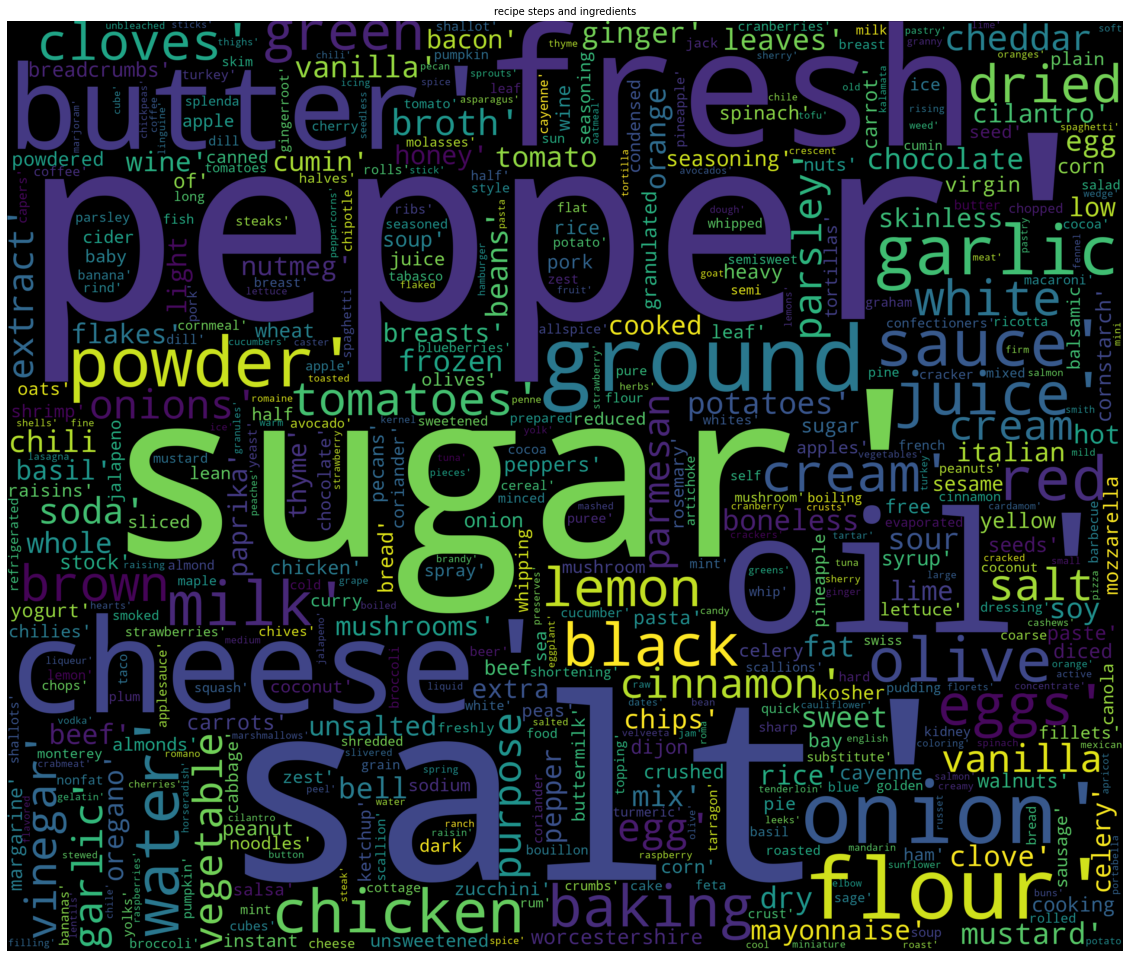

<Figure size 432x288 with 0 Axes>

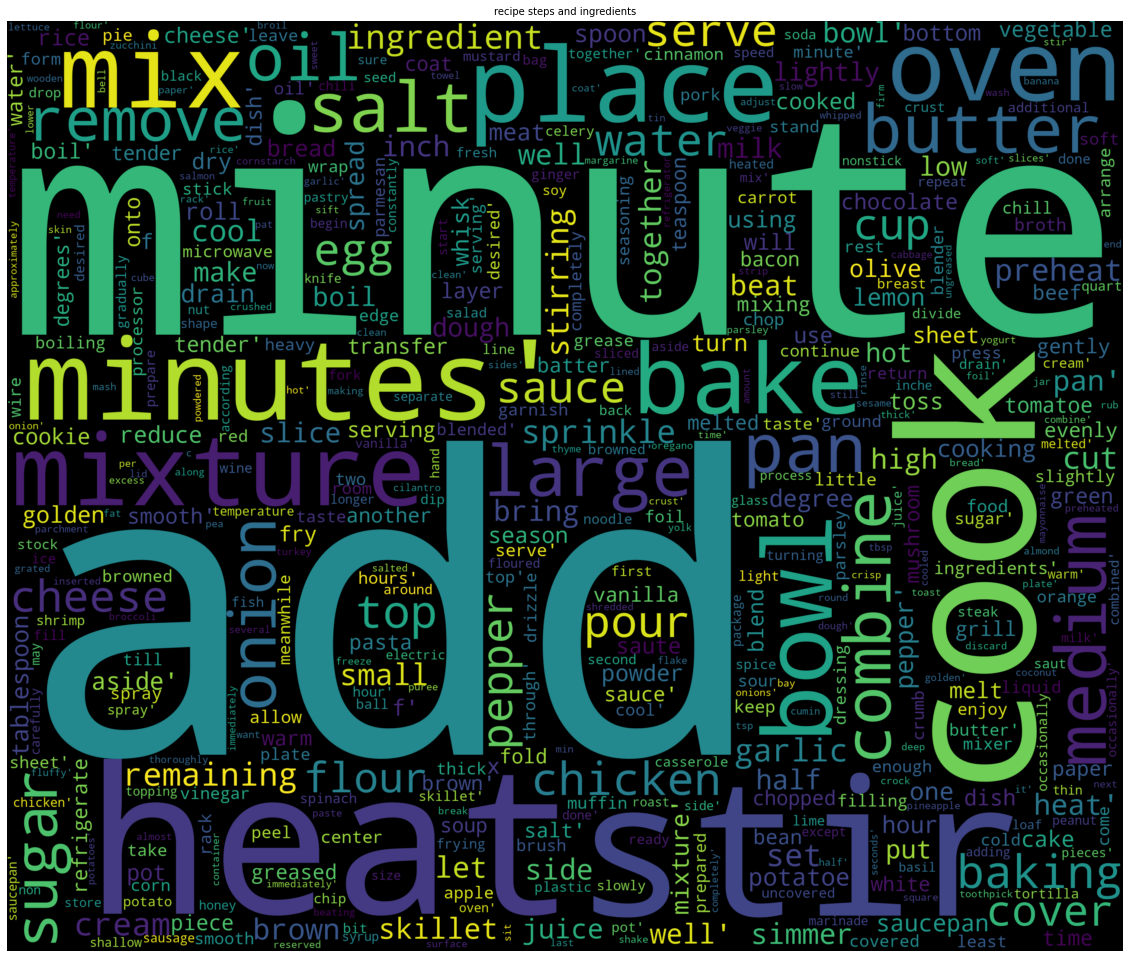

<Figure size 432x288 with 0 Axes>

In [7]:
# visualise the ingredient
x_train_ingre = train_original["ingredients"].str.replace(r"([\[\]0-9,\./-:&]+)", "",regex= True)
all_ingredients = " ".join(x_train_ingre)

# visualise the steps
x_train_steps = train_original["steps"].str.replace(r"([\[\]0-9,\./-:&]+)", "",regex= True)
all_steps = " ".join(x_train_steps)
from wordcloud import WordCloud, STOPWORDS
def wordcloud(data, name):
    wordcloud = WordCloud(stopwords=STOPWORDS,max_words=500,
                          background_color='black',min_font_size=6,
                          width=3000,collocations=False,
                          height=2500
                         ).generate(data)

    plt.figure(figsize=(20, 20))
    plt.title("recipe steps and ingredients", size=10)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.savefig("{}.png".format(name))
    return wordcloud

wc_ingredient = wordcloud(all_ingredients, "wordcloud_ingredients")
wc_step = wordcloud(all_steps, "wordcloud_steps")

## Preporcessing

In [8]:
x_train = (train_original["ingredients"] + train_original["steps"] + train_original["name"]).str.replace(r"([\[\]0-9,\./-:&]+)", "",regex= True)
y_train = train_original["duration_label"]
x_test = (test_original["ingredients"] + test_original["steps"] + test_original["name"]).str.replace(r"([\[\]0-9,\./-:&]+)", "",regex= True)

## Todense Method & Learning Curve Plot Function

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [10]:
# https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [11]:
# https://mlcourse.ai/articles/topic4-part5-validation/
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )    

def plot_learning_curve(degree, alpha, pipeline, X, y, titleName):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=5)
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.title(titleName)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()

## Logistic Regression

In [12]:
# logistic_regression = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
#                       ("tf_idf",TfidfTransformer()),
#                       ('selector', SelectKBest()), 
#                       ('to_dense', DenseTransformer()),
#                       ('model', LogisticRegression(max_iter = 1000))])
# logistic_parameters={
#         'selector__score_func' :[chi2, f_classif],
#         'selector__k':list(range(500,600,20))
#     }

# kfold = StratifiedKFold(n_splits=5, shuffle = True,random_state=7)
# grid_search = GridSearchCV(logistic_regression,logistic_parameters, scoring = "accuracy", cv = kfold)
# grid_result = grid_search.fit(x_train, y_train)
# grid_result.best_score_
# 0.7537499999999999
# grid_search.best_params_
# selector__k': 540,
# 'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}

logistic_regression = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
                      ("tf_idf",TfidfTransformer()),
                      ('selector', SelectKBest(f_classif, k = 540)), 
                      ('to_dense', DenseTransformer()),
                      ('model', LogisticRegression(max_iter = 1000))])
np.mean(cross_val_score(logistic_regression, x_train,y_train, cv=5))
# 0.7540250000000001

0.753975

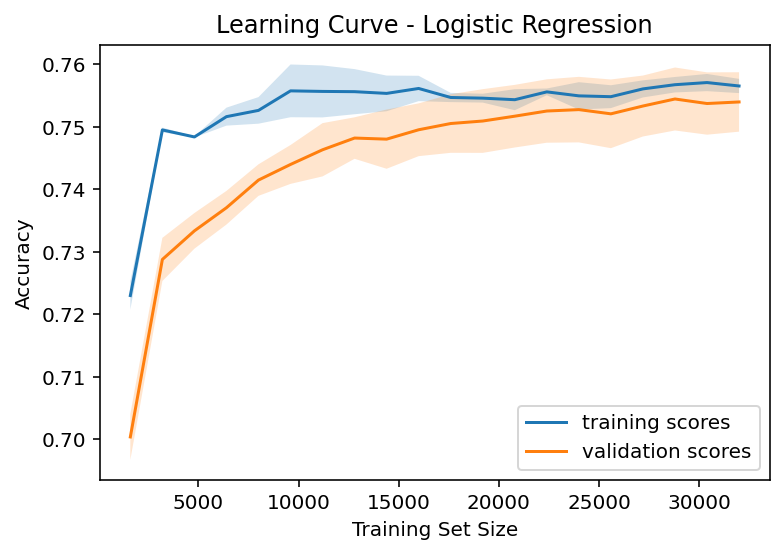

In [55]:
# plot_learning_curve(2, 0.05, logistic_regression, x_train, y_train, 'Learning Curve - Logistic Regression')

In [13]:
# Generate the prediction CSV with Logistic Regression

logistic_regression.fit(x_train, y_train)
output = logistic_regression.predict(x_test)

field_order = ["id", 'duration_label']
with open("LR.csv", 'w', encoding="utf-8", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, field_order)
    writer.writeheader()
    for i in range(len(output)):
        writer.writerow(dict(zip(field_order, [str(i+1), str(output[i])])))
    print("finish")

finish


## Multinomial Naive Bayes

In [14]:
# multinomialNB = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
#                       ("tf_idf",TfidfTransformer()),
#                       ('selector', SelectKBest(f_classif)),
#                       ('to_dense', DenseTransformer()),
#                       ('model', MultinomialNB())])
# multinomialNB_parameters={
#         'selector__k':list(range(500,600,20)),
#         'model__alpha': [0.001, 0.01, 0.1]
#     }

# kfold = StratifiedKFold(n_splits=5, shuffle = True,random_state=7)
# grid_search_mnb = GridSearchCV(multinomialNB,multinomialNB_parameters, scoring = "accuracy", cv = kfold)
# grid_result_mnb = grid_search_mnb.fit(x_train, y_train)
# grid_search_mnb.best_params_
# {'model__alpha': 0.001, 'selector__k': 580}
# grid_result_mnb.best_score_
# 0.675525

multinomialNB = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
                      ("tf_idf",TfidfTransformer()),
                      ('selector', SelectKBest(f_classif, k=580)),
                      ('to_dense', DenseTransformer()),
                      ('model',  MultinomialNB(alpha = 0.001))])
np.mean(cross_val_score(multinomialNB, x_train,y_train, cv=5))
# 0.6757000000000001

0.6757000000000001

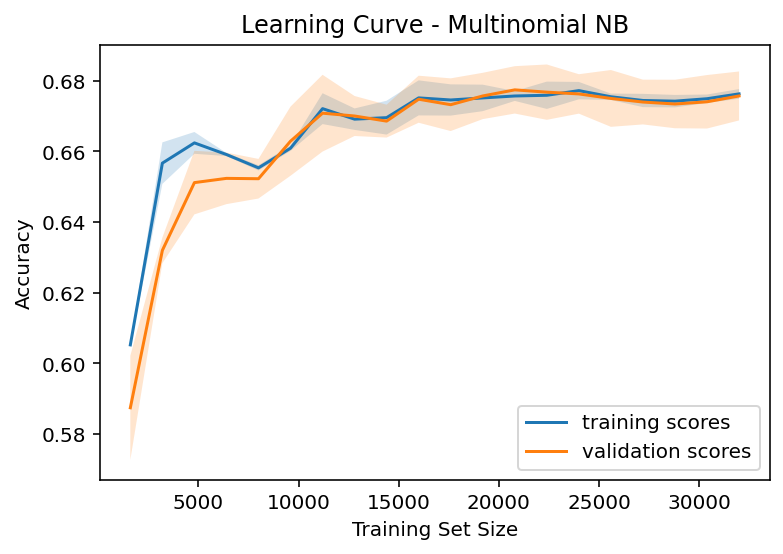

In [59]:
# plot_learning_curve(2, 0.05, multinomialNB, x_train, y_train, 'Learning Curve - Multinomial NB')

In [15]:
# Generate the prediction CSV with Multinomial Naive Bayes

multinomialNB.fit(x_train, y_train)
output = multinomialNB.predict(x_test)

field_order = ["id", 'duration_label']
with open("MNB.csv", 'w', encoding="utf-8", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, field_order)
    writer.writeheader()
    for i in range(len(output)):
        writer.writerow(dict(zip(field_order, [str(i+1), str(output[i])])))
    print("finish")

finish


## Decision Tree

In [16]:
# decision_tree = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
#                       ("tf_idf",TfidfTransformer()),
#                       ('selector', SelectKBest()), 
#                       ('to_dense', DenseTransformer()),
#                       ('model', DecisionTreeClassifier())])

# decision_tree_parameters={
#         'selector__score_func' :[chi2, f_classif],
#         'selector__k':list(range(500,600,20)),
#         'model__max_depth': [1, 2, 3]
#     }
# kfold = StratifiedKFold(n_splits=5, shuffle = True,random_state=7)
# grid_search_dt = GridSearchCV(decision_tree,decision_tree_parameters, scoring = "accuracy", cv = kfold)
# grid_result_dt = grid_search_dt.fit(x_train, y_train)

# grid_search_dt.best_params_
# {'model__max_depth': 3,
#  'selector__k': 500,
#  'selector__score_func': <function sklearn.feature_selection._univariate_selection.chi2(X, y)>}
# grid_result_dt.best_score_
# 0.6742999999999999

# since the max_depth is 3, so we assume to increase max_depth can increase the accuracy
# when max_depth = 5, cross vaslidation accuracy = array([0.720125, 0.719125, 0.7245  , 0.7175  , 0.730375])
# max_depth = 10, cross validation average accuracy = 0.7355
# max_depth = 11, cross validation average accuracy = 0.7341
# max_depth = 12 cross validation average accuracy = 0.73107499999999
# so we finally set max_depth at 10
decision_tree = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
                      ("tf_idf",TfidfTransformer()),
                      ('selector', SelectKBest(chi2, k = 500)), 
                      ('to_dense', DenseTransformer()),
                      ('model', DecisionTreeClassifier(max_depth = 10))])
np.mean(cross_val_score(decision_tree, x_train,y_train, cv=5))

0.735925

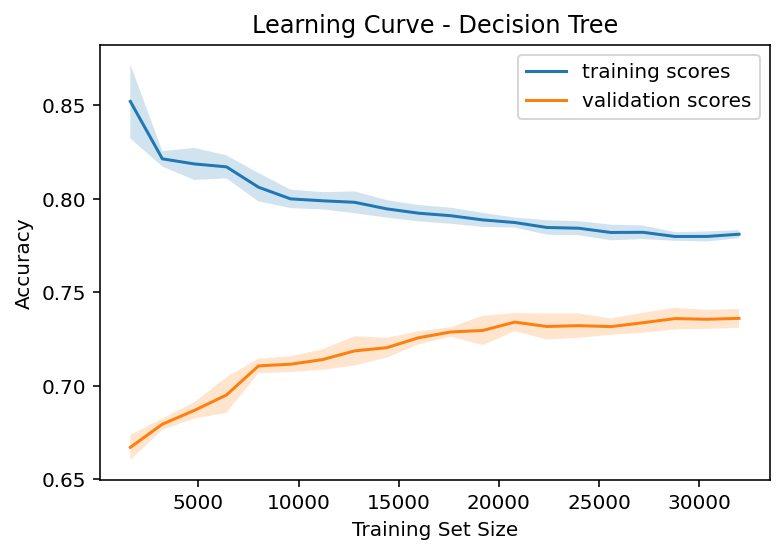

In [72]:
# plot_learning_curve(2, 0.05, decision_tree, x_train, y_train, 'Learning Curve - Decision Tree')

In [17]:
# Generate the prediction CSV with Decision Tree

decision_tree.fit(x_train, y_train)
output = decision_tree.predict(x_test)

field_order = ["id", 'duration_label']
with open("DT.csv", 'w', encoding="utf-8", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, field_order)
    writer.writeheader()
    for i in range(len(output)):
        writer.writerow(dict(zip(field_order, [str(i+1), str(output[i])])))
    print("finish")

finish


## Support Vector Machine

In [18]:
from sklearn import svm
# svm = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
#                       ("tf_idf",TfidfTransformer()),
#                       ('selector', SelectKBest()), 
#                       ('to_dense', DenseTransformer()),
#                       ('model', svm.LinearSVC(max_iter=10000))])

# svm_parameters={
#         'selector__score_func' :[chi2, f_classif],
#         'selector__k':list(range(500,600,20)),
#         'model__C': [1, 0.1, 0.01]
#     }
# kfold = StratifiedKFold(n_splits=5, shuffle = True,random_state=7)
# grid_search_svm = GridSearchCV(svm,svm_parameters, scoring = "accuracy", cv = kfold)
# grid_result_svm = grid_search_svm.fit(x_train, y_train)

# grid_search_svm.best_params_
# {'model__C': 1,
#  'selector__k': 500,
#  'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}
# grid_result_svm.best_score_
# 0.7569999999999999

svm_model = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
                      ("tf_idf",TfidfTransformer()),
                      ('selector', SelectKBest(f_classif, k = 500)), 
                      ('to_dense', DenseTransformer()),
                      ('model', svm.LinearSVC(C = 5, max_iter=10000))])
np.mean(cross_val_score(svm_model, x_train,y_train, cv=5))

# C = 2, average accuracy = 0.7571749999999999
# C = 5, average accuracy = 0.7574249999999999
# C = 10, average accuracy = 0.757

0.7574249999999999

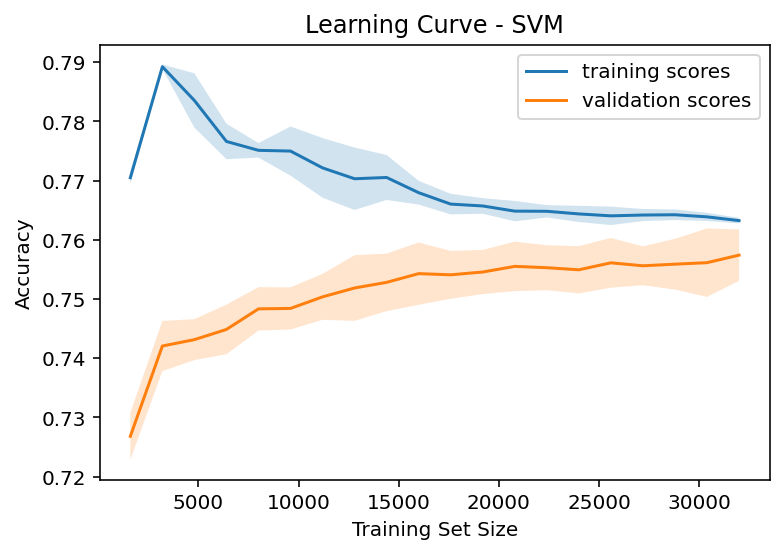

In [65]:
# plot_learning_curve(2, 0.05, svm_model, x_train, y_train, 'Learning Curve - SVM')

In [19]:
# Generate the prediction CSV with SVM

svm_model.fit(x_train, y_train)
output = svm_model.predict(x_test)

field_order = ["id", 'duration_label']
with open("SVM.csv", 'w', encoding="utf-8", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, field_order)
    writer.writeheader()
    for i in range(len(output)):
        writer.writerow(dict(zip(field_order, [str(i+1), str(output[i])])))
    print("finish")

finish


## Random Forest (This is for comparison with Decision Tree and Base of Stacking Model)

In [20]:
# random_forest = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
#                       ("tf_idf",TfidfTransformer()),
#                       ('selector', SelectKBest()), 
#                       ('to_dense', DenseTransformer()),
#                       ('model', RandomForestClassifier())])
# random_forest_parameters={
#         'selector__score_func' :[chi2, f_classif],
#         'selector__k':list(range(500,600,20)),
#         'model__n_estimators': [100, 150, 200, 300, 500]
#     }

# kfold = StratifiedKFold(n_splits=5, shuffle = True,random_state=7)
# grid_search_rf = GridSearchCV(random_forest,random_forest_parameters, scoring = "accuracy", cv = kfold)
# grid_result_rf = grid_search_rf.fit(x_train, y_train)

# grid_result_rf.best_score_
# 0.7729999999999999

# grid_search_rf.best_params_
# {'model__n_estimators': 500,
#  'selector__k': 560,
#  'selector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>}


from sklearn.ensemble import RandomForestClassifier
random_forest = Pipeline([('cv', CountVectorizer(stop_words='english',ngram_range=(1, 2))),
                      ("tf_idf",TfidfTransformer()),
                      ('selector', SelectKBest(f_classif, k = 560)), 
                      ('to_dense', DenseTransformer()),
                      ('model', RandomForestClassifier(n_estimators=500, max_depth = 10))])
np.mean(cross_val_score(random_forest, x_train,y_train, cv=5))


# 0.751725

0.75165

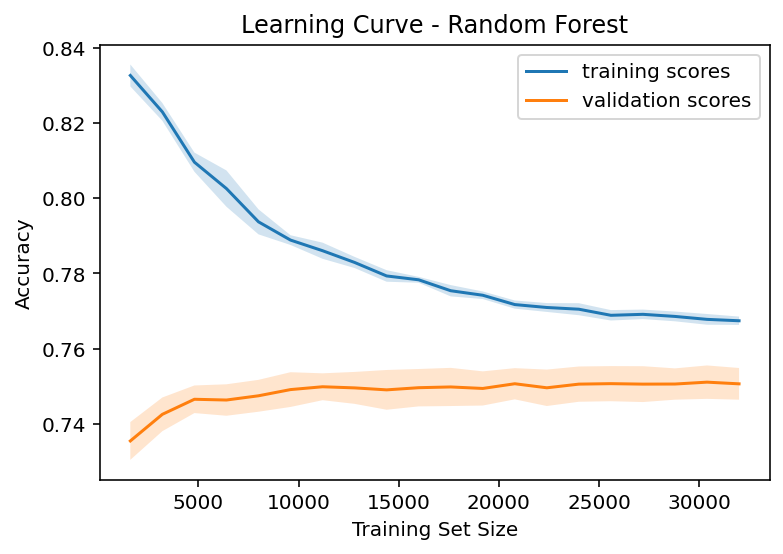

In [76]:
# plot_learning_curve(2, 0.05, random_forest, x_train, y_train, 'Learning Curve - Random Forest')

In [21]:
# Generate the prediction CSV with Random Forest (This part only used for Kaggle submission for comparison to DT)

random_forest.fit(x_train, y_train)
output = random_forest.predict(x_test)

field_order = ["id", 'duration_label']
with open("RF.csv", 'w', encoding="utf-8", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, field_order)
    writer.writeheader()
    for i in range(len(output)):
        writer.writerow(dict(zip(field_order, [str(i+1), str(output[i])])))
    print("finish")

finish


## Stacking Model

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

# Base model: Logistic Regression, Random Forest, SVM, MNB
base_learners = [
    ('Logistic', logistic_regression),
    ('rf', random_forest),
    ('svm', svm_model),
    ("mnb", multinomialNB)
]

# Meta-classifier: Logistic Regression
meta_classifier_lr = LogisticRegression(max_iter = 10000)
clf = StackingClassifier(estimators=base_learners, final_estimator= meta_classifier_lr)
np.mean(cross_val_score(clf, x_train,y_train, cv=5))
# 0.766575

0.765375

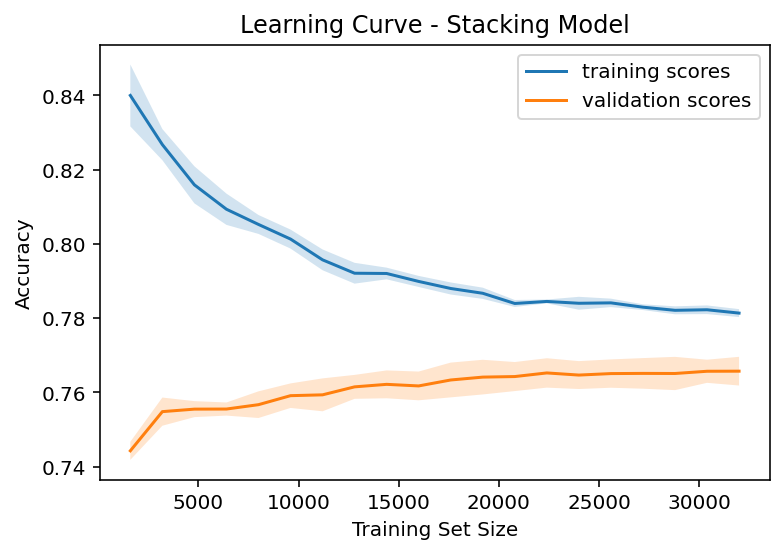

In [80]:
# plot_learning_curve(2, 0.05, clf, x_train, y_train, 'Learning Curve - Stacking Model')

In [23]:
# Generate the prediction CSV with Stacking Model

clf.fit(x_train, y_train)
output = clf.predict(x_test)

field_order = ["id", 'duration_label']
with open("Stacking.csv", 'w', encoding="utf-8", newline='') as csvfile:
    writer = csv.DictWriter(csvfile, field_order)
    writer.writeheader()
    for i in range(len(output)):
        writer.writerow(dict(zip(field_order, [str(i+1), str(output[i])])))
    print("finish")

finish
